In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import random
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Reshape, BatchNormalization, Conv2D, Input, Lambda, Multiply, Flatten
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = "/content/drive/MyDrive/Project/BabyFace/Train"
test_dir = "/content/drive/MyDrive/Project/BabyFace/Test"

seed = 42
img_height = 299
img_width = 299

In [ ]:
BATCH_SIZE = 32

# Preprocessing function for the DenseNet model
preprocess_fun = tf.keras.applications.densenet.preprocess_input

# Data generator for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2,  # 20% of the data will be used for validation
    preprocessing_function=preprocess_fun
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",  # Specify this is the training subset
    seed=12  # Seed for reproducibility
)

# Data generator for validation
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fun,
    validation_split=0.2  # Must match the training generator
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",  # Specify this is the validation subset
    seed=12  # Seed for reproducibility
)

# Test data generator (no augmentation)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    shuffle=False,  # Do not shuffle for test data
    color_mode="rgb",
    class_mode="categorical",
    seed=12  # Seed for reproducibility
)


Found 1161 images belonging to 3 classes.
Found 289 images belonging to 3 classes.
Found 364 images belonging to 3 classes.


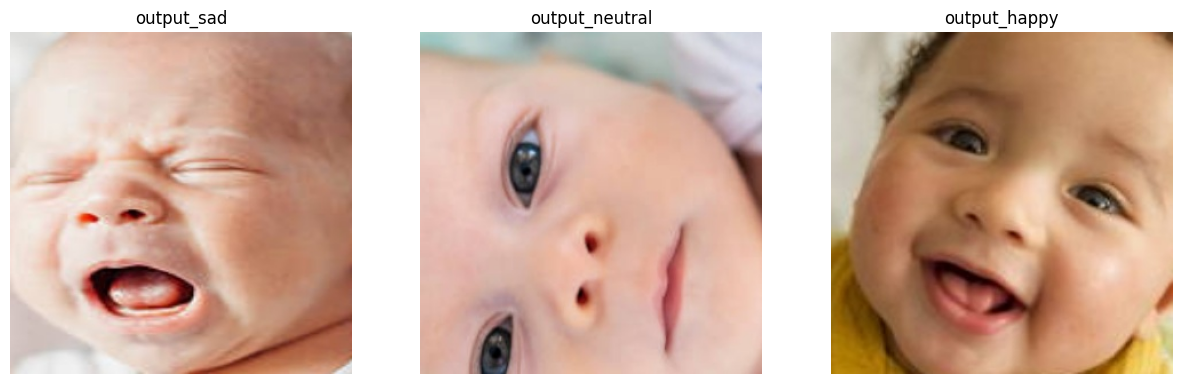

In [ ]:
img_width = 299
img_height = 299

def show_images_from_folders(folder_path):
    class_folders = os.listdir(folder_path)

    plt.figure(figsize=(15, 10))


    for i, class_name in enumerate(class_folders):
        class_folder_path = os.path.join(folder_path, class_name)
        image_files = os.listdir(class_folder_path)

        sample_image = random.choice(image_files)

        img_path = os.path.join(class_folder_path, sample_image)
        img = load_img(img_path, target_size=(img_width, img_height))

        plt.subplot(1, len(class_folders), i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

show_images_from_folders(train_dir)

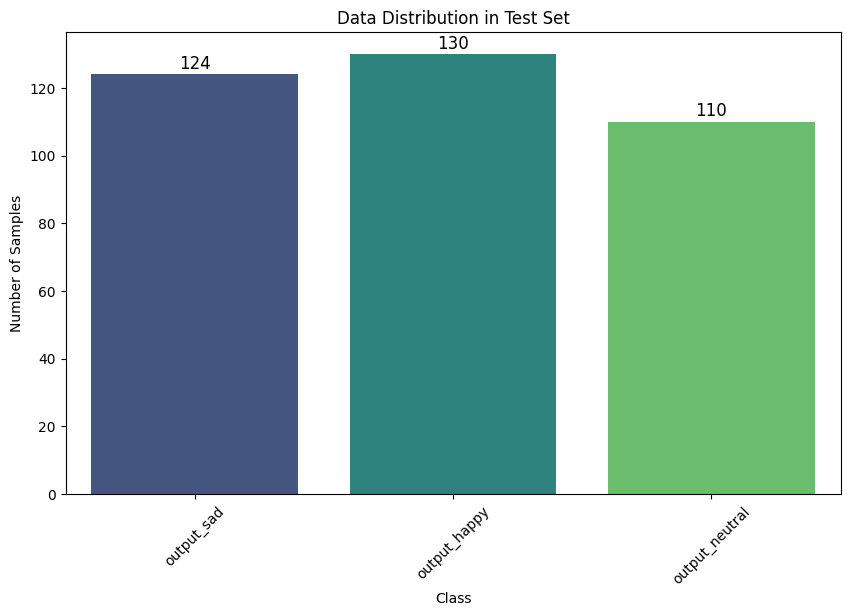

In [ ]:

def plot_data_distribution(folder_path):
    class_folders = os.listdir(folder_path)

    class_counts = {class_name: len(os.listdir(os.path.join(folder_path, class_name))) for class_name in class_folders}

    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")

    for i, count in enumerate(counts):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12, color='black')

    plt.title('Data Distribution in Test Set')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

plot_data_distribution(test_dir)

### Inception V3 Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
EPOCHS = 20
FINE_TUNING_EPOCHS = 20
num_classes = 3
LR = 0.01
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Happy', 'Neutral', 'Sadness']
CLASS_LABELS_EMOJIS = ["😊" , "😐 ", "😔" ]

In [ ]:
def feature_extractor(inputs):
    base_model = tf.keras.applications.InceptionV3(input_shape=(img_height,img_width, num_classes),
                                               include_top=False,
                                               weights="imagenet") # Remove (inputs) here
    base_model.trainable = False
    x = base_model(inputs, training=False) # Now this line should work correctly
    return x

def classifier(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', name='classification')(x)
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(img_height,img_width, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.01),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [ ]:
def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([input_tensor, se])
    return x

def feature_extractor(inputs):
    base_model = tf.keras.applications.InceptionV3(input_shape=(img_height, img_width, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    # Unfreeze some layers
    base_model.trainable = False
    x = base_model(inputs, training=False)  # Set training=True to enable batch normalization
    x = se_block(x)  # Add SE block here
    return x

def classifier(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', name='classification')(x)
    return x

def final_model(inputs):
    feature_extractor_output = feature_extractor(inputs)
    classification_output = classifier(feature_extractor_output)
    return classification_output

def define_compile_model():
    inputs = Input(shape=(img_height, img_width, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  # Lower learning rate for fine-tuning
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]
model = define_compile_model()
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 8, 8, 2048)     │     21,802,784 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 2048)     │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 128)      │        262,144 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 2048)     │        262,144 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 8, 8, 2048)     │              0 │ inception_v3[0][0],    │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │      2,098,176 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │        524,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classification (Dense)    │ (None, 3)              │          1,539 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,959,779 (95.21 MB)

 Trainable params: 3,152,899 (12.03 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [ ]:
batch_size = 32  # batch size of 32 performs the best
epochs = 20

# Use Adam optimizer
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs= epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 540s 12s/step - accuracy: 0.4732 - loss: 1.3637 - val_accuracy: 0.7163 - val_loss: 0.9020 - learning_rate: 0.0100
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 392s 10s/step - accuracy: 0.6217 - loss: 0.9350 - val_accuracy: 0.7785 - val_loss: 0.8505 - learning_rate: 0.0100
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 400s 11s/step - accuracy: 0.6426 - loss: 0.8623 - val_accuracy: 0.8062 - val_loss: 0.7877 - learning_rate: 0.0100
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 379s 10s/step - accuracy: 0.6843 - loss: 0.8049 - val_accuracy: 0.8408 - val_loss: 0.7367 - learning_rate: 0.0100
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 377s 10s/step - accuracy: 0.7120 - loss: 0.7136 - val_accuracy: 0.8547 - val_loss: 0.6954 - learning_rate: 0.0100
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 377s 10s/step - accuracy: 0.7170 - loss: 0.6609 - val_accuracy: 0.8201 - val_loss: 0.6515 - learning_rate: 0.0100
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 383s 10s/step - accuracy: 0.7133 - loss: 0.6735 - 

In [ ]:
model.save("model.h5")

OSError: [Errno 95] Unable to synchronously create file (unable to open file: name = 'drive/model.h5', errno = 95, error message = 'Operation not supported', flags = 13, o_flags = 242)

### Training Results

In [ ]:
df = pd.DataFrame(history.history)
x = px.line(data_frame= df , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
x = px.line(data_frame= df ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming 'history' is already defined
df = pd.DataFrame(history.history)

# Create subplots: 2 rows, 1 column
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Accuracy vs Number of Epochs", "Loss vs Number of Epochs"))

# Add accuracy trace
fig.add_trace(go.Scatter(x=df.index, y=df['accuracy'], mode='lines+markers', name='Accuracy', marker=dict(color='blue')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['val_accuracy'], mode='lines+markers', name='Validation Accuracy', marker=dict(color='lightblue')),
              row=1, col=1)

# Add loss trace
fig.add_trace(go.Scatter(x=df.index, y=df['loss'], mode='lines+markers', name='Loss', marker=dict(color='red')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['val_loss'], mode='lines+markers', name='Validation Loss', marker=dict(color='salmon')),
              row=2, col=1)

# Update x and y axes titles
fig.update_xaxes(title_text="Number of Epochs", row=2, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=2, col=1)

# Update layout
fig.update_layout(showlegend=True,
                  title_text='Model Performance',
                  title_x=0.5,
                  title_y=0.94)

# Show the figure
fig.show()


### Model Evaluation

In [ ]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

12/12 ━━━━━━━━━━━━━━━━━━━━ 125s 11s/step - accuracy: 0.7086 - loss: 0.7340
12/12 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step


### Hyperparameter Tuning

### Confusion Matrix

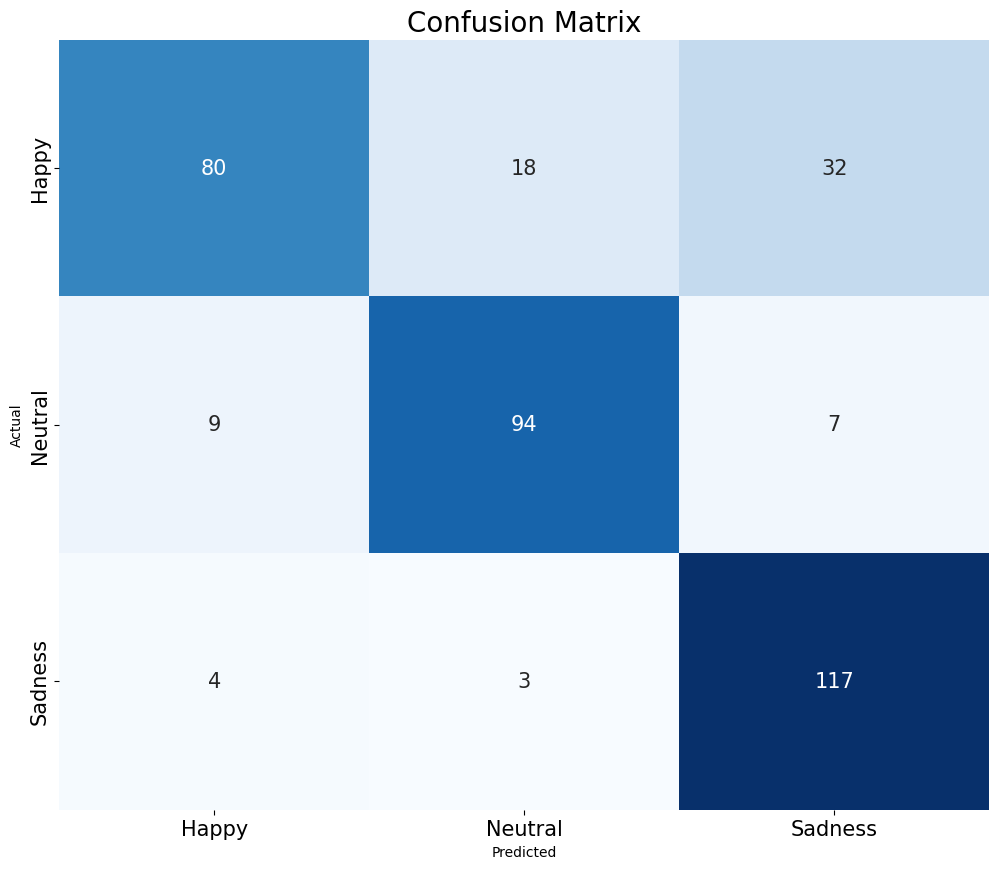

In [ ]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (12,10))
plt.title('Confusion Matrix', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt='g')

### Classification Report

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.62      0.72       130
           1       0.82      0.85      0.84       110
           2       0.75      0.94      0.84       124

    accuracy                           0.80       364
   macro avg       0.81      0.80      0.80       364
weighted avg       0.81      0.80      0.79       364



### Multiclass AUC Curve

ROC AUC score: 0.9367754498249004


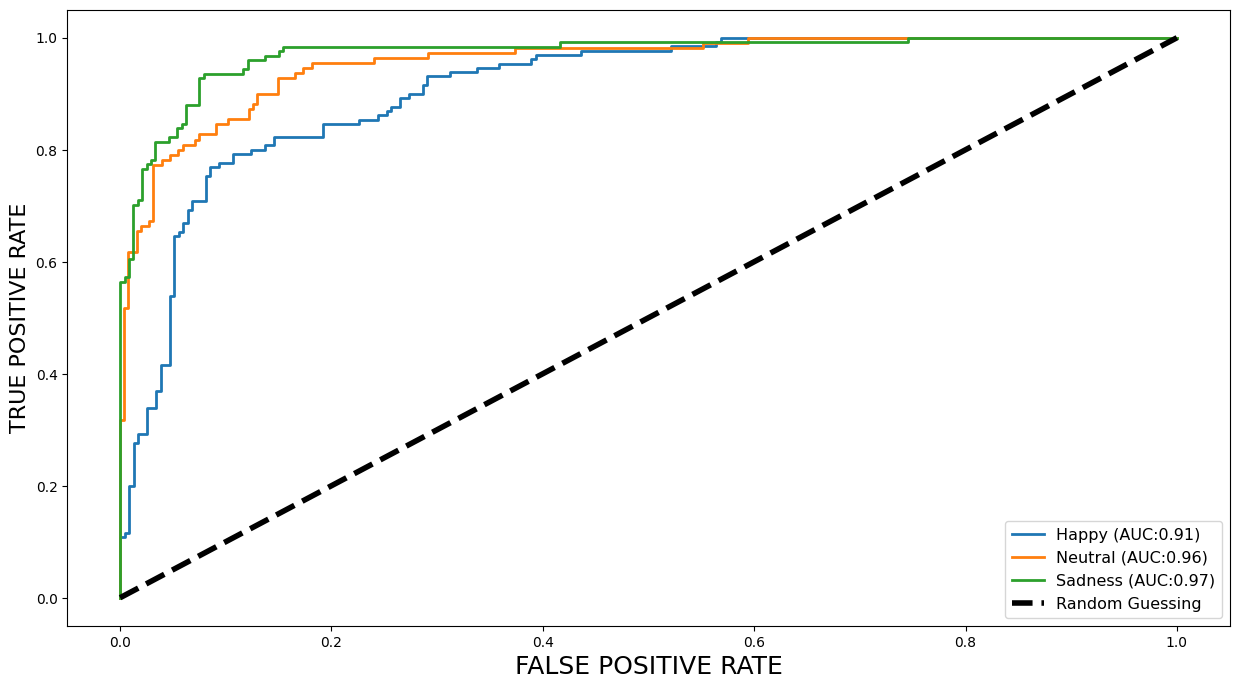

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8810310287606272
